## This is a python notebook that attempts to the solve MyNewsDesk test

-- by Vaibhav Saxena

In [ ]:
#Libraries installed in this task:
"""
pandas==2.2.3
numpy==2.1.3
transformers==4.46.1
torch # for torch use the following if you have M2: pip3 install --pre torch torchvision torchaudio --index-url https://download.pytorch.org/whl/nightly/cpu
matplotlib==3.9.2
seaborn==0.13.2
wordcloud==1.9.3
nltk==3.9.1
vaderSentiment==3.3.2
accelerate==1.1.0
#langdetect==1.0.9
sentence-transformers==3.2.1
bertopic
"""

In [2]:
import pandas as pd 
import numpy as np 

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

import transformers
import torch

import textwrap

In [68]:
print(pd.__version__)
print(np.__version__)
print(transformers.__version__)
print(torch.__version__)

In [3]:
ls   

articles_xformed.csv  mnd_play.ipynb
data/                 requirements.txt


In [4]:
# Taking a sneak peak at the data

articles = pd.read_csv('./data/fake_articles.csv')
press_releases = pd.read_csv('./data/fake_pressreleases.csv')

In [5]:
articles.head()

,journalist_email,outlet_name,publish_date,headline,text
0,david.wilson@example.com,Political Review,2024-04-18,Key Political Developments in 2024,The political landscape in 2024 is marked by s...
1,david.wilson@example.com,Political Review,2024-07-25,The Impact of Social Media on Politics,Social media is playing an increasingly influe...
2,david.wilson@example.com,Political Review,2024-10-30,The Role of Youth in Politics,Youth are playing an increasingly important ro...
3,david.wilson@example.com,Political Review,2025-01-15,The Role of Media in Shaping Public Opinion,The media plays a crucial role in shaping publ...
4,david.wilson@example.com,Political Review,2025-04-20,The Impact of Political Polarization on Society,Political polarization is having a profound im...


In [6]:
press_releases.head()

,newsroom,publish_date,headline,text
0,InnovatePR,2023-01-15,Launch of Next-Gen AI Platform,InnovateTech announces the launch of its next-...
1,InnovatePR,2023-02-20,Partnership with Global FinTech Leaders,InnovateTech forms a strategic partnership wit...
2,InnovatePR,2023-03-10,Expansion into European Markets,InnovateTech expands its operations into Europ...
3,InnovatePR,2023-04-05,Awarded Best Tech Innovator 2023,InnovateTech receives the Best Tech Innovator ...
4,InnovatePR,2023-05-22,Launch of Sustainable Tech Initiative,InnovateTech launches a new sustainability ini...


In [7]:
articles.shape, press_releases.shape, articles.isna().sum().sum(), press_releases.isna().sum().sum()

((50, 5), (37, 4), np.int64(0), np.int64(0))

####  Observation 1: The two dataframes seem to be mostly disjoint to each other and cant be joined. The idea here is to:

    - find a way to score each jounalist in the articles df based on how they have headlined each text, perhaps even vice versa
    - employ that fomula to press releases df for each journalist across each headlines and text pairs across each news room and rank them

### Starting with articles df

In [8]:
articles.sample(2)

,journalist_email,outlet_name,publish_date,headline,text
13,james.taylor@example.com,Fashion Daily,2025-03-30,The Impact of Technology on Fashion Design,"Technology is revolutionizing fashion design, ..."
2,david.wilson@example.com,Political Review,2024-10-30,The Role of Youth in Politics,Youth are playing an increasingly important ro...


In [9]:
print(f'The number of journalists are {articles.journalist_email.nunique()}')

The number of journalists are 10


#### Observation 2: Every journalist seems to be working for one outlet and hence leaving the importance of outlet_name to none since its not being recalled ever anywhere in press releases as well, so we can safely drop em

In [10]:
articles_df = articles.copy()

In [11]:
articles_df = articles_df.drop('outlet_name', axis = 1)

In [12]:
# Sneak peaking into some headlines and some of their texts

for row in articles_df[['headline', 'text']].sample(3).itertuples(index=False):
    head, txt = row
    wrapped_txt = "\n".join(textwrap.wrap(txt, width=80))
    print(f"Headline: {head}\nText:\n{wrapped_txt}\n{'-'*80}")


Headline: DIY Home Improvement Projects for Beginners
Text:
DIY home improvement projects are a great way for beginners to enhance their
living spaces without breaking the bank. Simple projects such as painting walls,
installing shelves, and updating fixtures can make a big difference. Painting is
one of the easiest and most cost-effective ways to refresh a room. Installing
shelves can add storage and display space, while updating fixtures such as
faucets and light switches can modernize a home. With a little creativity and
effort, beginners can tackle DIY projects and transform their homes into more
functional and stylish spaces.
--------------------------------------------------------------------------------
Headline: Winter Gardening Tips for a Healthy Garden
Text:
Winter gardening requires special care and attention to ensure plants stay
healthy during the colder months. Key tips for winter gardening include
protecting plants from frost, maintaining soil health, and planning for sp

#### Observation 3: There are about 10 articles in other languages viz., German and Swedish but press releases have all the text in English

### Some first hand data analysis. Heres what I am looking to do:

   1. Plot a simple word cloud
   2. Bar chart for most common words
   3. Length of text distribution
   4. Sentiment analysis
   5. N-grams analysis: justa bi-gram for now

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk import FreqDist
from nltk.tokenize import word_tokenize

In [14]:
# Downloading some of the stopwords for the languages I think I detected
nltk.download('stopwords')
stop_words_en = set(stopwords.words('english'))
stop_words_de = set(stopwords.words('german'))
stop_words_sv = set(stopwords.words('swedish'))
stop_words = stop_words_en.union(stop_words_de).union(stop_words_sv)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/i39986/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/i39986/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

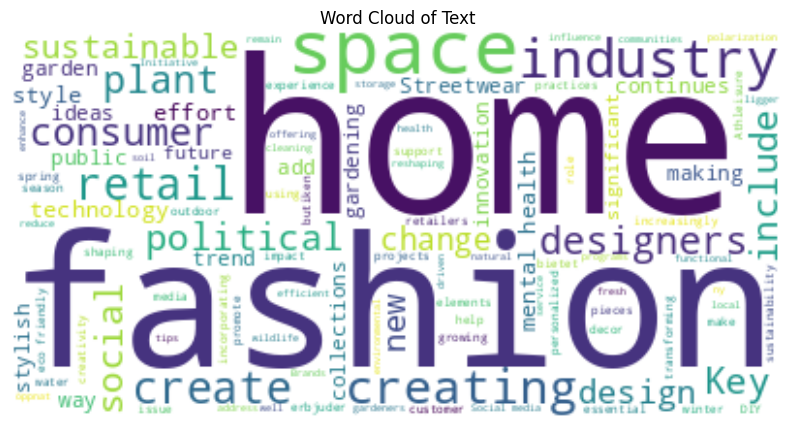

In [16]:
# Word Cloud for text

text_combined = ' '.join(articles['text'])
wordcloud = WordCloud(stopwords=stop_words, background_color='white').generate(text_combined)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Text')
plt.show()


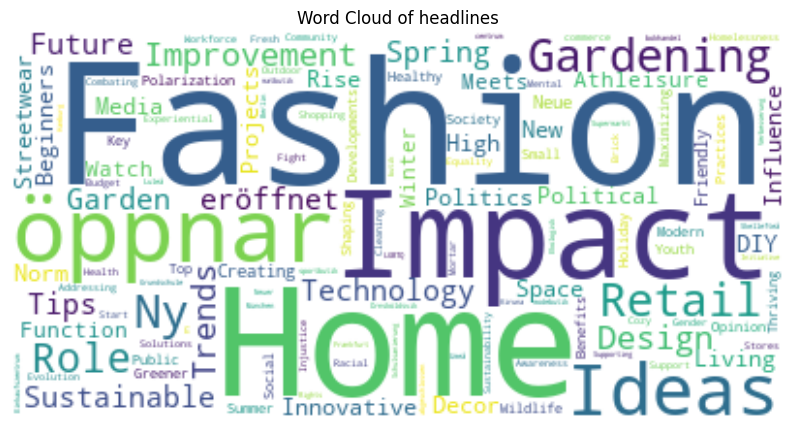

In [23]:
# Word Cloud for headlines

text_combined = ' '.join(articles['headline'])
wordcloud = WordCloud(stopwords=stop_words, background_color='white').generate(text_combined)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of headlines')
plt.show()

In [17]:
# Tokenizing considering multiple languages
words = word_tokenize(text_combined.lower())
words = [word for word in words if word.isalnum() and word not in stop_words]
freq_dist = FreqDist(words)

In [18]:
# Bar chart for the most common words
common_words = freq_dist.most_common(10)
words, counts = zip(*common_words)

/var/folders/sc/v7prj051159dbrztnt9ty7r40000gp/T/ipykernel_78189/4267188374.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='viridis')


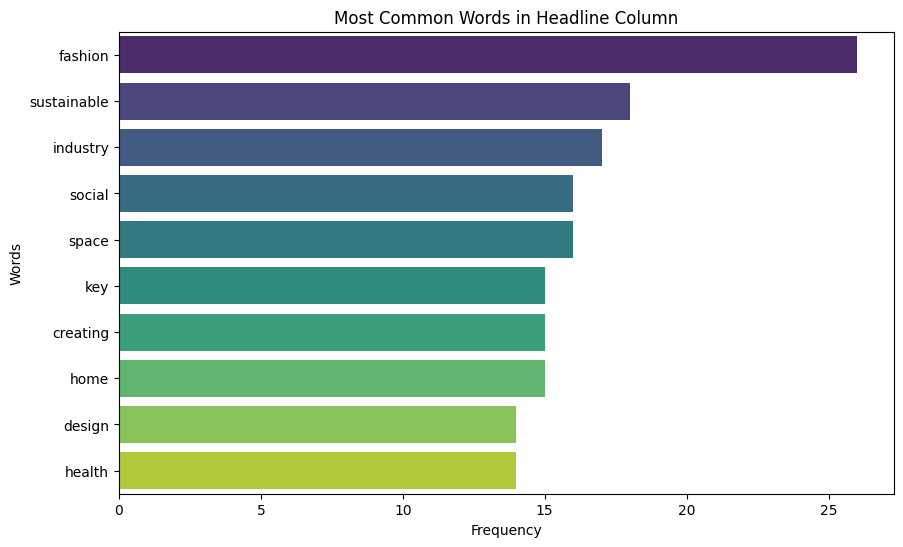

In [19]:
plt.figure(figsize=(10, 6))
sns.barplot(x=list(counts), y=list(words), palette='viridis')
plt.title('Most Common Words in Headline Column')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()

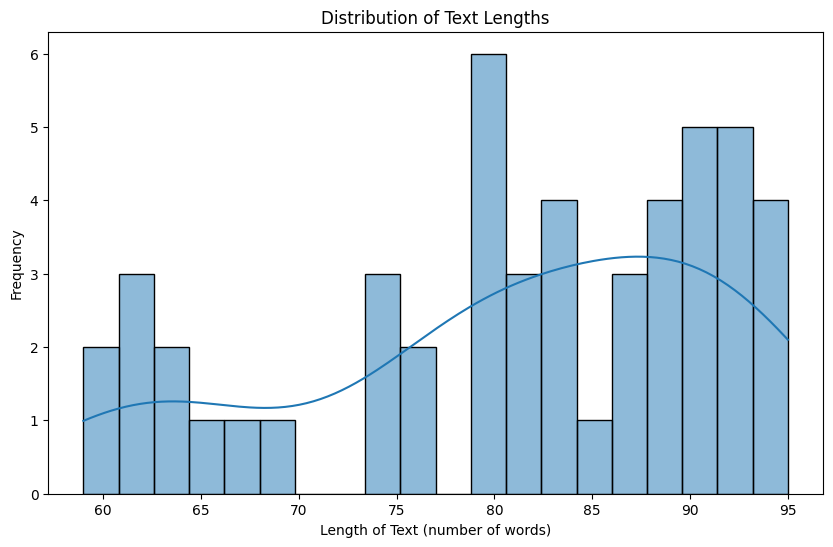

In [20]:
articles_df['text_length'] = articles_df['text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
sns.histplot(articles_df['text_length'], bins=20, kde=True)
plt.title('Distribution of Text Lengths')
plt.xlabel('Length of Text (number of words)')
plt.ylabel('Frequency')
plt.show()

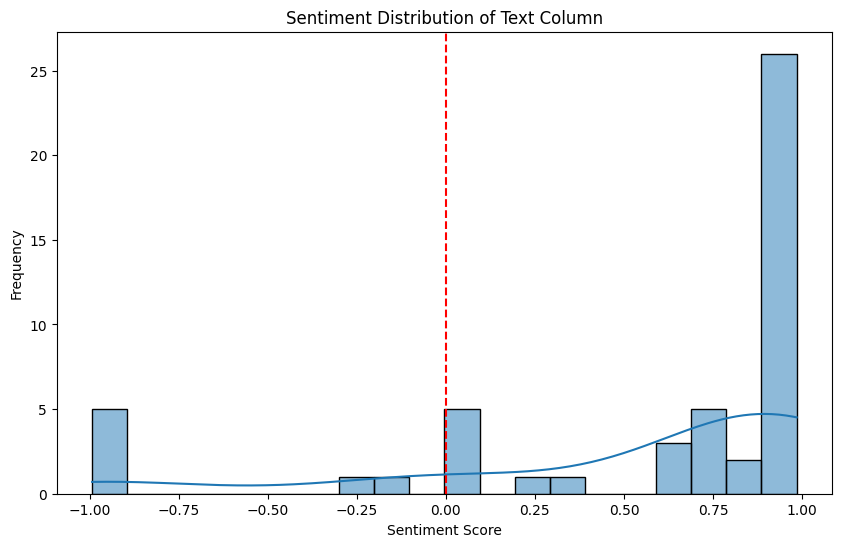

In [21]:
# Sentiment analysis

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def get_sentiment(text):
    score = analyzer.polarity_scores(text)
    return score['compound'] 

articles_df['sentiment'] = articles_df['text'].apply(get_sentiment)

plt.figure(figsize=(10, 6))
sns.histplot(articles_df['sentiment'], bins=20, kde=True)
plt.title('Sentiment Distribution of Text Column')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.axvline(0, color='red', linestyle='--')
plt.show()


In [22]:
## Lets explore the more negative ones:

print("\n".join(textwrap.wrap(articles_df[articles_df.sentiment < -0.9].sample()['text'].iloc[0], width=80)))

Ein neues Einkaufszentrum hat in Berlin eröffnet und bietet eine Vielzahl von
Geschäften, Restaurants und Unterhaltungsmöglichkeiten. Das Einkaufszentrum ist
modern gestaltet und bietet eine angenehme Atmosphäre für Besucher. Die
Eröffnung zog viele Menschen an, die die neuen Einkaufsmöglichkeiten und das
vielfältige Angebot erkunden wollten. Das Einkaufszentrum plant regelmäßige
Veranstaltungen und Sonderaktionen, um die Attraktivität für die Besucher zu
erhöhen.


### Observation 3: Dont think its negative all, its highly promotional and only carries positivity aroudnit. Further research shows that vaderSentiment is primarily trained on English. Maybe we can transformers pipeline

In [24]:
from transformers import pipeline

sentiment_pipeline = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment", device= "mps")


In [25]:
articles_df['sentiment_2'] = articles_df['text'].apply(lambda x: sentiment_pipeline(x)[0]['label'])

/var/folders/sc/v7prj051159dbrztnt9ty7r40000gp/T/ipykernel_78189/482324900.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')


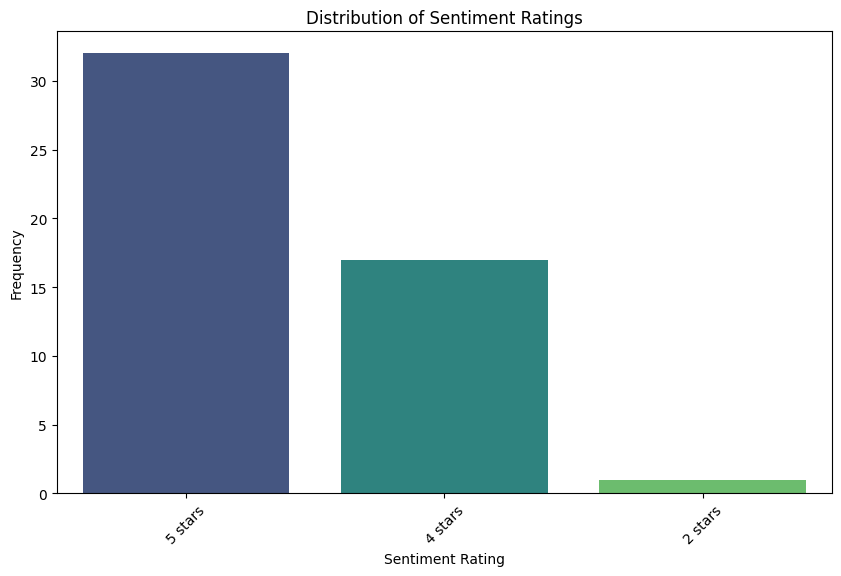

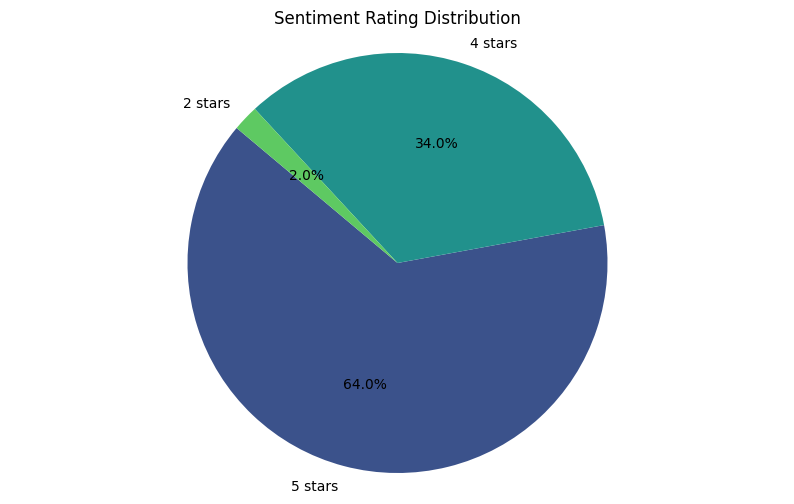

In [27]:
sentiment_counts = articles_df['sentiment_2'].value_counts()

# Bar Chart Visualization
plt.figure(figsize=(10, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')
plt.title('Distribution of Sentiment Ratings')
plt.xlabel('Sentiment Rating')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

# Pie Chart Visualization
plt.figure(figsize=(10, 6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('viridis', len(sentiment_counts)))
plt.title('Sentiment Rating Distribution')
plt.axis('equal')  # Equal aspect ratio ensures pie is drawn as a circle.
plt.show()


In [28]:
### Lets see the 2 stars texts

two_star_text = articles_df[articles_df['sentiment_2'] == '2 stars']

for index, row in two_star_text.iterrows():
    print(f"text: {row['headline']}")
    wrapped_text = textwrap.fill(row['text'], width=80)
    print(f"Text: {wrapped_text}")
    print('-' * 60) 

text: The Impact of Political Polarization on Society
Text: Political polarization is having a profound impact on society, affecting public
discourse, governance, and social cohesion. Divisive rhetoric and ideological
divides are creating tensions and conflicts within communities. The media and
social media platforms are amplifying polarized views, contributing to the
spread of misinformation and echo chambers. Political polarization is also
affecting governance, making it challenging to achieve consensus and implement
policies. Addressing political polarization requires efforts to promote
dialogue, understanding, and collaboration across different perspectives.
------------------------------------------------------------


#### Observation 4: This one seems to be carrying a somewhat of a negative connotation but mostly as a sense of information conveyance. Would hardly call it negative.

### Lets try some multilingual cosine similarity to score the text against their headlines and vice versa, and perhaps generating some extractive summary

In [29]:
from sentence_transformers import SentenceTransformer, util
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import pandas as pd

similarity_model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')
tokenizer = AutoTokenizer.from_pretrained("facebook/mbart-large-cc25")
summarizer_model = AutoModelForSeq2SeqLM.from_pretrained("facebook/mbart-large-cc25")

def compute_similarity_score(text1, text2):
    embedding1 = similarity_model.encode(text1, convert_to_tensor=True)
    embedding2 = similarity_model.encode(text2, convert_to_tensor=True)
    similarity_score = util.pytorch_cos_sim(embedding1, embedding2).item()
    return similarity_score

def summarize_text(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True)
    summary_ids = summarizer_model.generate(inputs['input_ids'], max_length=50, min_length=25, length_penalty=2.0)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

def evaluate_headline_alignment(row):
    headline, text = row['headline'], row['text']
    similarity_full_text = compute_similarity_score(headline, text)
    summary = summarize_text(text)
    similarity_summary = compute_similarity_score(headline, summary)
    
    return pd.Series({'similarity_full_text': similarity_full_text, 'similarity_summary': similarity_summary, 'generated_sumamry': summary})


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [30]:
articles_df[['similarity_full_text', 'similarity_summary', 'generated_summary']] = articles_df.apply(evaluate_headline_alignment, axis=1)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [31]:
articles_df.sample(6)

,journalist_email,publish_date,headline,text,text_length,sentiment,sentiment_2,similarity_full_text,similarity_summary,generated_summary
23,michael.smith@example.com,2024-11-20,The Influence of Streetwear on High Fashion,Streetwear is having a significant influence o...,79,0.5994,5 stars,0.864771,0.724941,into the industry is having a significant infl...
22,michael.smith@example.com,2024-08-15,The Rise of Athleisure: Fashion Meets Function,"Athleisure, the trend of wearing athletic-insp...",95,0.9509,5 stars,0.739733,0.495004,the trend. Athleisure continues to gaining to ...
49,anna.mueller@example.com,2025-03-20,Initiative zur Verbesserung der Schulverpflegu...,Eine neue Initiative zur Verbesserung der Schu...,67,-0.9661,5 stars,0.735132,0.683989,neue Initiative zur Verbesserung der Initiativ...
32,sarah.brown@example.com,2024-09-22,The Impact of E-commerce on Brick-and-Mortar S...,The rise of e-commerce is having a profound im...,79,0.2732,5 stars,0.834974,0.638197,the future of the future of the gap between e-...
8,emily.jones@example.com,2024-09-25,Innovative Home Design Ideas for Modern Living,Innovative home design ideas are transforming ...,90,0.7269,5 stars,0.859914,0.494661,"into the key trends. Open floor plans, multifu..."
40,erik.svensson@example.com,2024-02-10,Ny butik öppnar i Umeå centrum,En ny butik har öppnat i Umeå centrum och erbj...,62,0.0000,5 stars,0.876107,0.667632,"ार्थियों, har öppnat i Umeå centrum och erbjud..."


### Lets perform some topic modelling as well

In [38]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer

embedding_model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')

texts = articles_df['text'].tolist()
embeddings = embedding_model.encode(texts, show_progress_bar=True)

topic_model = BERTopic(nr_topics="auto", embedding_model=embedding_model)

topics, probabilities = topic_model.fit_transform(texts, embeddings)

articles_df['topic'] = topics
articles_df['topic_probability'] = probabilities

In [52]:
topic_info = topic_model.get_topic_info()
print(topic_info.head(10)) 

   Topic  Count              Name  \
0      0     25  0_and_to_the_are   
1      1     25  1_and_the_is_die   

                                      Representation  \
0  [and, to, the, are, can, for, as, such, of, with]   
1  [and, the, is, die, och, of, fashion, und, to,...   

                                 Representative_Docs  
0  [Youth are playing an increasingly important r...  
1  [Athleisure, the trend of wearing athletic-ins...  


### Observation 5: This seems to be too small a dataset for berttopic to determine 10 topics. 

# Lets try an LLM

### What am I trying to do below:

    1. Load an LLM, Gemma-2 2B Instruction model in this instance. It will be loaded from huggingface
    2. Create an elaborated context for an LLM to understand a journalist in a comprehensive manner
    3. The context will involve features like, short assessment of the journalist, motivation of the literature, quality of the text and additionally recalling of any relevant event in the short past pertaining to the text and the published date, amongst other features. These features will be derived by an LLM by keeping a few methods in mind viz., clarity, coherence, grammar, and engagement.
    4. Prompt the LLM to score the journalist just based off of the aforementioned info from 0 to 10. The score will not affect the final relevance.
    5. Create a context from the press release file for each data and that context will have only headline, text and the news room info in it.
    6. Prompt and LLM to find a relation between these two contexts using various off-the-top barometers such as writing style, sentiment, and alignment with newsroom expectations and also the explanation for that score.
    7. That score adjudged by the LLM will eventually serve as a relevance of a journalist to a newsroom.


In [56]:
#pip install huggingface_hub

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [32]:

import torch
from transformers import pipeline

pipe = pipeline(
    "text-generation",
    model="google/gemma-2-2b-it",
    model_kwargs={"torch_dtype": torch.bfloat16},
    device="mps",
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [33]:
def analyze_journalist(headline, text):
    prompt = f"""
    Given the headline: '{headline}', and the content: '{text}',
    - Determine the type of journalist who wrote the headline and article in 2 words (e.g., professional, casual, motivational, political, etc).
    """

    messages = [{"role": "user", "content": prompt}]
    
    outputs = pipe(messages, max_new_tokens=8)
    assistant_response = outputs[0]["generated_text"][-1]["content"].strip()
    
    return assistant_response

def analyze_motivation(headline, text):
    prompt = f"""
    Given the headline: '{headline}', and the content: '{text}',
    - Try to understand and tell the motivation behind writing this article in 10 or so words.
    """

    messages = [{"role": "user", "content": prompt}]
    
    outputs = pipe(messages, max_new_tokens=16)
    assistant_response = outputs[0]["generated_text"][-1]["content"].strip()
    
    return assistant_response

def score_journalist(headline, text):
    prompt = f"""
    Given the headline: '{headline}', and the content: '{text}',
    - Score the quality of the text between 0 and 10, based on clarity, coherence, grammar, and engagement. Just the score in integer format and no explanation.
    - Make sure the final text generation is just an integer between 0 and 10. 0 being poor and 10 being perfect.
    """

    messages = [{"role": "user", "content": prompt}]
    
    outputs = pipe(messages, max_new_tokens=4)
    assistant_response = outputs[0]["generated_text"][-1]["content"].strip()
    
    return assistant_response


articles_df['analysis_journalist'] = articles_df.apply(lambda row: analyze_journalist(row['headline'], row['text']), axis=1)
articles_df['analysis_notivation'] = articles_df.apply(lambda row: analyze_motivation(row['headline'], row['text']), axis=1)
articles_df['llm_score'] = articles_df.apply(lambda row: score_journalist(row['headline'], row['text']), axis=1)

In [34]:
articles_df.head()

,journalist_email,publish_date,headline,text,text_length,sentiment,sentiment_2,similarity_full_text,similarity_summary,generated_summary,analysis_journalist,analysis_notivation,llm_score
0,david.wilson@example.com,2024-04-18,Key Political Developments in 2024,The political landscape in 2024 is marked by s...,90,0.7650,4 stars,0.807843,0.651899,political landscape in 20242424242424242424242...,**Political Journalist**,To inform readers about the major political tr...,7
1,david.wilson@example.com,2024-07-25,The Impact of Social Media on Politics,Social media is playing an increasingly influe...,88,0.8402,4 stars,0.877684,0.854067,the impact on social media is playing an incre...,**Political Journalist**,To explore the multifaceted impact of social m...,8
2,david.wilson@example.com,2024-10-30,The Role of Youth in Politics,Youth are playing an increasingly important ro...,89,0.9538,5 stars,0.810714,0.366581,into the voices of the next generation are hea...,**Informative**,To highlight the growing influence and importa...,8
3,david.wilson@example.com,2025-01-15,The Role of Media in Shaping Public Opinion,The media plays a crucial role in shaping publ...,75,-0.1280,4 stars,0.866587,0.592089,into public opinion is essential for promoting...,**Political Journalist**,To understand the impact of media on public op...,8
4,david.wilson@example.com,2025-04-20,The Impact of Political Polarization on Society,Political polarization is having a profound im...,76,-0.2960,2 stars,0.867234,0.634073,theorising polarization is having a profound i...,**Analytical Journalist**,To raise awareness about the negative societal...,8


In [35]:
def find_relevant_event(headline, text, publish_date):
    prompt = f"""
    Given the headline: '{headline}', the content: '{text}', and the publish date: '{publish_date}',
    identify a relevant event or development around that time which could be influencing the content of the article.
    Provide just one key event or notable occurrence that is likely relevant to the topic and around the publish date.
    """
    
    messages = [{"role": "user", "content": prompt}]
    
    outputs = pipe(messages, max_new_tokens=32)
    assistant_response = outputs[0]["generated_text"][-1]["content"].strip()
    
    return assistant_response

articles_df['relevant_event'] = articles_df.apply(lambda row: find_relevant_event(row['headline'], row['text'], row['publish_date']), axis=1)

In [36]:
for idx, row in articles_df.sample(5).iterrows():
    print(f"Headline: {row['headline']}")
    print("Text:\n", textwrap.fill(row['text'], width=50))
    print("Relevant Event:\n", textwrap.fill(row['relevant_event'], width=50))
    print("-" * 80)

Headline: Neue Grundschule in München eröffnet
Text:
 Eine neue Grundschule hat in München eröffnet, um
dem wachsenden Bedarf an Schulplätzen gerecht zu
werden. Die moderne Einrichtung bietet großzügige
Klassenzimmer, eine gut ausgestattete Bibliothek
und moderne Sportanlagen. Die Schulleitung betont
die Bedeutung von individueller Förderung und
digitalem Lernen. Eltern und Schüler sind
begeistert von den neuen Möglichkeiten, die die
Schule bietet. Die Eröffnung wurde mit einer
feierlichen Zeremonie und zahlreichen Gästen
gefeiert.
Relevant Event:
 **The Bavarian state government's announcement of
a new education funding plan for the 2024-2025
school year.**   This
--------------------------------------------------------------------------------
Headline: Top Home Improvement Trends for 2024
Text:
 Home improvement trends for 2024 are all about
sustainability, smart technology, and
personalization. Homeowners are increasingly
opting for eco-friendly materials and energy-
efficient appli

In [37]:
articles_df.text[0]

'The political landscape in 2024 is marked by significant developments and shifts. Key issues dominating the political discourse include climate change, healthcare reform, and economic inequality. Governments around the world are implementing policies to address these challenges, with varying degrees of success. International relations are also in the spotlight, with geopolitical tensions and trade negotiations shaping global dynamics. As elections approach in several countries, political parties are outlining their visions and strategies to address pressing issues. The political developments of 2024 are expected to have far-reaching implications for the future.'

In [38]:
articles_df.relevant_event[7]

'**The rise of "tiny house" movement and its increasing popularity.** \n\nThe publish date of June 20th, 2024,'

In [39]:
articles_df.to_csv('articles_xformed.csv', index= False)

# Newsroom

In [40]:
press_releases.sample(5)

,newsroom,publish_date,headline,text
15,EcoPress,2023-06-20,EcoPress Hosts Sustainability Summit,EcoPress hosts its annual Sustainability Summi...
22,GlamourGems,2023-03-08,International Women's Day Celebration,GlamourGems celebrates International Women's D...
23,GlamourGems,2023-04-22,Earth Day Eco-Friendly Jewelry Line,GlamourGems launches an eco-friendly jewelry l...
5,InnovatePR,2023-06-18,Release of Cybersecurity Suite,InnovateTech releases its latest cybersecurity...
8,InnovatePR,2023-09-09,InnovateTech Hosts Annual Tech Conference,"InnovateTech hosts its annual tech conference,..."


In [41]:
articles_formed = articles_df.copy()

In [42]:
articles_formed.sample(2)

,journalist_email,publish_date,headline,text,text_length,sentiment,sentiment_2,similarity_full_text,similarity_summary,generated_summary,analysis_journalist,analysis_notivation,llm_score,relevant_event
43,erik.svensson@example.com,2024-11-05,Ny bokhandel öppnar i Skellefteå,En ny bokhandel har öppnat i Skellefteå och er...,59,0.0000,5 stars,0.881533,0.741097,"मा, att bli bokhandel har öppnat i Skellefteft...",**Local News**,To announce the opening of a new bookstore in ...,8,**The release of the new Swedish National Libr...
6,emily.jones@example.com,2024-03-15,DIY Home Improvement Projects for Beginners,DIY home improvement projects are a great way ...,91,0.9044,4 stars,0.855077,0.551805,these days can tackle DIY projects and transfo...,**Informative**,To empower beginners to improve their homes af...,8,**The rise of home renovation shows and influe...


In [43]:
articles_formed.columns

Index(['journalist_email', 'publish_date', 'headline', 'text', 'text_length',
       'sentiment', 'sentiment_2', 'similarity_full_text',
       'similarity_summary', 'generated_summary', 'analysis_journalist',
       'analysis_notivation', 'llm_score', 'relevant_event'],
      dtype='object')

### Pinning a journalist against each newsroom

In [46]:
def create_journalist_context(row):
    return (
        f"Journalist Email: {row['journalist_email']}\n"
        f"Headline: {row['headline']}\n"
        f"Text: {row['text']}\n"
        f"Sentiment: {row['sentiment_2']}\n"
        f"Journalist Analysis: {row['analysis_journalist']}\n"
        f"Journalist Motivation: {row['analysis_notivation']}\n"
        f"Relevant Event: {row['relevant_event']}\n"
        f"Journalist Analysis: {row['analysis_journalist']}\n"
        f"Motivation: {row['analysis_notivation']}\n"
    )

def create_newsroom_context(row):
    return (
        f"Newsroom: {row['newsroom']}\n"
        f"Headline: {row['headline']}\n"
        f"Text: {row['text']}\n"
    )

def evaluate_fit(journalist_context, newsroom_context):
    prompt = (
        f"Compare the following two contexts:\n\n"
        f"Journalist Context:\n{journalist_context}\n\n"
        f"Newsroom Context:\n{newsroom_context}\n\n"
        "Based on writing style, sentiment, and alignment with newsroom expectations, "
        "Rate the journalist's suitability to work in this newsroom on a scale from 0 to 10.Just the score in integer format and no explanation."
        "Make sure the final text generation is just an integer between 0 and 10. 0 being not fit at all and 10 being a perfect fit."
    )
    
    messages = [{"role": "user", "content": prompt}]
    outputs = pipe(messages, max_new_tokens=4)
    score = outputs[0]["generated_text"][-1]["content"].strip()

    return score

In [47]:
results = []
for _, journalist_row in articles_formed.iterrows():
    journalist_context = create_journalist_context(journalist_row)
    for _, newsroom_row in press_releases.iterrows():
        newsroom_context = create_newsroom_context(newsroom_row)
        score = evaluate_fit(journalist_context, newsroom_context)
        results.append({
            "journalist_email": journalist_row["journalist_email"],
            "newsroom": newsroom_row["newsroom"],
            "score": score
        })

In [48]:
results_df = pd.DataFrame(results)

In [49]:
results_df[results_df.newsroom == 'InnovatePR']

,journalist_email,newsroom,score
0,david.wilson@example.com,InnovatePR,2
1,david.wilson@example.com,InnovatePR,2
2,david.wilson@example.com,InnovatePR,2
3,david.wilson@example.com,InnovatePR,2
4,david.wilson@example.com,InnovatePR,2
...,...,...,...
1818,anna.mueller@example.com,InnovatePR,2
1819,anna.mueller@example.com,InnovatePR,2
1820,anna.mueller@example.com,InnovatePR,2
1821,anna.mueller@example.com,InnovatePR,2


In [50]:
results_df.score.value_counts()

score
2    1697
3      66
7      48
6      24
4       9
8       6
Name: count, dtype: int64

In [52]:
results_df[results_df.newsroom == 'GlamourGems'].sample(20)

,journalist_email,newsroom,score
1398,olivia.thompson@example.com,GlamourGems,2
836,michael.smith@example.com,GlamourGems,2
1177,sarah.brown@example.com,GlamourGems,2
1319,olivia.thompson@example.com,GlamourGems,2
1027,olivia.davis@example.com,GlamourGems,3
1511,erik.svensson@example.com,GlamourGems,3
94,david.wilson@example.com,GlamourGems,2
358,emily.jones@example.com,GlamourGems,2
282,emily.jones@example.com,GlamourGems,2
288,emily.jones@example.com,GlamourGems,2


## Explanation for the scores

In [66]:
def reason_fit(journalist_context, newsroom_context):
    prompt = (
        f"Compare the following two contexts:\n\n"
        f"Journalist Context:\n{journalist_context}\n\n"
        f"Newsroom Context:\n{newsroom_context}\n\n"
        "Based on writing style, sentiment, and alignment with newsroom expectations, "
        "Rate the journalist's suitability to work in this newsroom by telling why do they fit there. If they dont fit there, explain why do they not fit there. Thanks"
    )
    
    messages = [{"role": "user", "content": prompt}]
    outputs = pipe(messages, max_new_tokens=32)
    motivation = outputs[0]["generated_text"][-1]["content"].strip()

    return motivation

In [67]:
results_motivation = []
for _, journalist_row in articles_formed.iterrows():
    journalist_context = create_journalist_context(journalist_row)
    for _, newsroom_row in press_releases.iterrows():
        newsroom_context = create_newsroom_context(newsroom_row)
        llm_motivation = reason_fit(journalist_context, newsroom_context)
        results_motivation.append({
            "journalist_email": journalist_row["journalist_email"],
            "newsroom": newsroom_row["newsroom"],
            "motivation": llm_motivation
        })

In [68]:
motivations_df = pd.DataFrame(results_motivation)

In [61]:
results_df['context'] = journalist_context

In [63]:
results_df.to_csv('scores.csv', index= False)

# TBC on app.py